# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [ ]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [ ]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [ ]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше).
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Для начала выведите необходимые формулы аналитически, а затем реализуйте их в коде. Ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.  Везде считайте $r < m, n$.

Покажем как эффективно вычислять фробениусову норму данной матрицы:
$(A - UV^{T})_{F} = \sqrt{(A - UV^{T})_{F}^{2}} = \sqrt{Tr((A - UV^{T})(A - UV^{T})^{T})} = \sqrt{Tr(AA^{T}) - 2*Tr(AVU^{T}) + Tr(UV^{T}VU^{T})} = \sqrt{A_{F}^{2} - 2 * Tr(U^{T}AV) + Tr((U^{T}U)(V^{T}V))}$. Первые член это норма фробениусова матрицы A, второй член можно вычисляется эффективно путем последовательного умноженим на A, третий член вычисляется описанным разбиением за $O(max(n,m) * r^{2})$. Значит, мы научились вычислять все эффективно.

In [ ]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    return np.sqrt(A_norm*A_norm - 2 * np.trace((U.transpose() @ A) @ VT.transpose()) + np.trace((U.transpose() @ U) @ (VT @ VT.transpose())))

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

Вспомним что ортпопроекторы на соответсвующие подпространства записываются как $P(L_1) = U_1U_1^{T}, P_(L_2) = U_2U_2^{T}$.$||(I - P(L_1))P(L_2)|| = ||(I - U_1U_1^{T})U_2U_2^{T}|| = ||((I - U_1U_1^{T})U_2)U_2^{T}|| = ||(U_2 - U_1(U_1^{T}U_2))U_2^{T}||$. Несложно заметить что матрица $(U_2 - U_1(U_1^{T}U_2))$ Вычилсяется за $O(mr^{2})$ и при этом имеет размер m*r. Для нахождения нормы исходной матрицы необходимо найти первое сингулярное число данной матрицы(так как диаг матрица из свд данной матрицы будет диаг матрицей из свд для исходной), что тоже делается за $O(mr^{2})$. Значит алгоритм имеет итоговую сложность $O(mr^{2})$

**YOUR WORDS GO HERE**

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [ ]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
    """
    return np.linalg.norm((U2 - U1@(U1.transpose() @ U2)).transpose(), 2)

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию.

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [ ]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration

        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    fs = []
    deltas = []
    dists = []
    A_norm = sparse_norm(A)
    ## Инициализируем U и V
    X = np.matrix(np.random.randn(A.shape[1], rank))
    U = A @ X
    U, _ = np.linalg.qr(U)
    ## А теперь улучшаем решение
    last_delta = 1000000000
    while last_delta >= tolerance:
        # Первый шаг
        V = A.transpose() @ U
        f = als_functional(A, A_norm, U, V.transpose())
        fs = np.append(fs, f)
        Qx, Rx = np.linalg.qr(V)
        # Второй шаг
        U_prev = U
        U_ = A @ Qx
        U, W = np.linalg.qr(U_)
        last_delta = f - als_functional(A, A_norm, U_, Qx.transpose())
        deltas = np.append(deltas, last_delta)
        dists = np.append(dists, dist_between_subspaces(U_prev, U))
        if debug:
            print(f"Номер итерации: {len(fs)}, delta_k={deltas[-1]}")
    VT = U.transpose() @ A
    return U, VT, fs, deltas, dists

Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

Номер итерации: 1, delta_k=110.73250530843438
Номер итерации: 2, delta_k=10.284722399708244
Номер итерации: 3, delta_k=2.46685957567729
Номер итерации: 4, delta_k=0.9299696914649758
Номер итерации: 5, delta_k=0.4633932941248986
Номер итерации: 6, delta_k=0.27306982377831446
Номер итерации: 7, delta_k=0.17383691524537426
Номер итерации: 8, delta_k=0.11475324340290172
Номер итерации: 9, delta_k=0.07822652125651075


[]

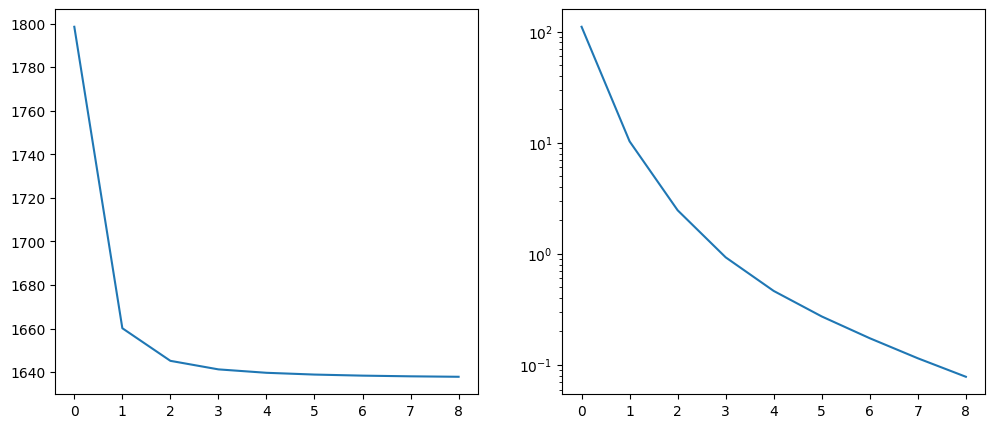

In [ ]:
rank = 30

U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy()

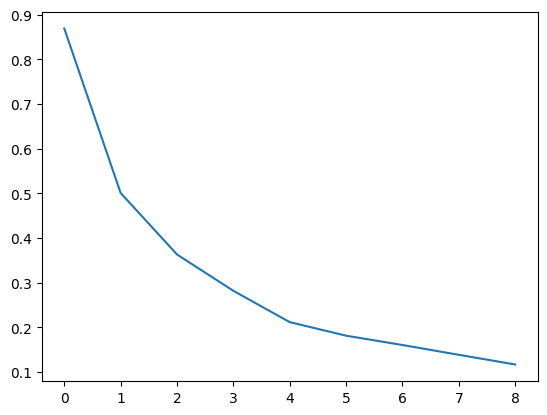

In [ ]:
# опционально

plt.plot(dists)

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [ ]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
U1, X1, VT1 = svds(A_train, 30)
X1 = np.diag(X1)
U2, X2, VT2 = randomized_svd(A_train, 30)
X2 = np.diag(X2)
#sparsesvd
print(als_functional(A_train, A_norm, U1, X1@VT1))
#rand_svd
print(als_functional(A_train, A_norm, U2, X2@VT2))
#als
print(als_functional(A_train, A_norm, U_als, VT_als))


# TO BE FILLED

1637.1605373328543
1637.2600969302343
1637.7592442381888


### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

In [ ]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array

        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    recs = V @ (V.T @ score_mat.T)
    recs = recs.T
    for i in range(recs.shape[0]):
      recs[i, :] = np.flip(np.argsort(recs[i, :]))
    return np.array(recs[:,:pred_am])

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [ ]:
from scipy.sparse import find

def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    print(hit_idx)
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [ ]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs

    """
    hits = evaluate_model(A_test, max(pred_ams), V)
    hits = np.array(hits)
    hit_list = []
    for ind in pred_ams:
      res = np.sum(hits < ind)/len(hits)
      hit_list = np.append(hit_list, res)
    return hit_list









Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [ ]:
# TO BE FILLED
hit_rates = get_hit_rates(A_test[:1000, :], [10], VT1.T)
print(hit_rates)
#Получилось +- ок



[0, 10, 3, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 2, 10, 9, 10, 10, 8, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 7, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

[100, 37, 100, 100, 100, 93, 29, 52, 79, 28, 100, 100, 100, 100, 5, 100, 100, 85, 32, 100, 53, 27, 47, 100, 49, 100, 100, 100, 47, 6, 100, 52, 53, 100, 32, 100, 85, 100, 24, 100, 100, 100, 100, 19, 65, 100, 21, 100, 100, 51, 100, 33, 100, 63, 23, 100, 49, 100, 100, 100, 100, 31, 30, 62, 100, 79, 100, 100, 100, 100, 100, 100, 100, 100, 83, 100, 100, 8, 100, 83, 21, 100, 100, 100, 100, 12, 100, 100, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 24, 60, 100, 4, 0, 100, 100, 100, 100, 100, 100, 100, 7, 22, 100, 100, 100, 100, 19, 100, 22, 3, 100, 19, 100, 0, 15, 100, 100, 100, 1, 100, 100, 100, 100, 42, 0, 24, 100, 16, 19, 45, 100, 100, 100, 53, 100, 94, 100, 99, 42, 44, 11, 100, 100, 100, 98, 20, 100, 100, 100, 30, 100, 100, 100, 95, 100, 100, 100, 4, 100, 36, 26, 20, 28, 100, 66, 65, 100, 48, 53, 100, 100, 100, 16, 100, 100, 100, 82, 100, 11, 100, 100, 100, 82, 100, 100, 11, 56, 100, 100, 100, 100, 100, 15, 100, 100, 100, 100, 9, 100, 100, 28, 100, 100, 64, 12, 100, 100, 100, 34, 65, 1

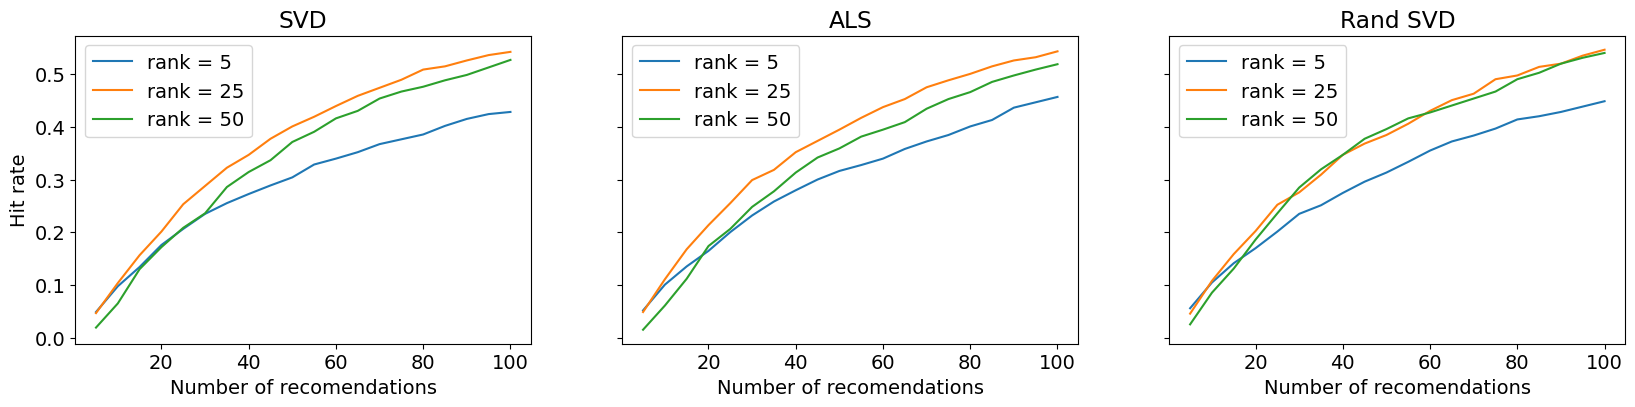

In [ ]:
from scipy.sparse.linalg import svds

pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    VT_als, _ = np.linalg.qr(VT_als.T)
    VT_als = VT_als.T
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, VT.T)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

**YOUR WORDS GO HERE**

25 ранг показал лучшие результаты

## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

In [3]:
def tuck2full(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            A: d-dimensional numpy array of the size (n1, n2, ..., nd)
    """

    map1 = [Us[i] for i in range(len(Us))]
    map2 = [[i + len(Us), i] for i in range(len(Us))]

    map = [val for pair in zip(map1, map2) for val in pair]
    f = [i for i in range(len(Us))]
    s = [i + len(Us) for i in range(len(Us))]



    A = np.einsum(G, f, *map, s, optimize = "optimal")

    return A


2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [32]:
import math
def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)
    """
    dims = A.shape
    dimmul = 1
    for h in dims:
        dimmul *= h
    fucktak1 = []
    fucktak2 = []
    for i in range(len(A.shape)):
        order = list(range(len(A.shape)))
        order[0], order[i] = order[i], order[0]
        Ai = np.transpose(A, order)
        Ai = np.reshape(Ai, (dims[i], dimmul//dims[i]), order = 'f')
        ### Все равно подбор ранга это эвристика Xd
        Ui, _, _, = randomized_svd(Ai, dims[i]//2)
        fucktak2 += [Ui]
        Ui = Ui.T
        fucktak1 += [Ui]

    G = tuck2full(A, fucktak1)
    A = tuck2full(G, fucktak2)

    return G, fucktak2, A

3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [33]:
from sklearn.utils.extmath import randomized_svd
size_i = 25
size_j = 50
size_k = 75
size_l = 100

i, j, k, l = np.meshgrid(np.arange(size_i), np.arange(size_j), np.arange(size_k), np.arange(size_l), indexing='ij')

tensor = 1 / (i + j + k + l + 1)
G, full, A = hosvd(tensor, 0.000001)
print(np.linalg.norm(tensor - A)/np.linalg.norm(tensor))
## Получили нужную точность с запасом

1.2641839125673347e-11


4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

Доказательство:
Разложим по первой моде:
$G_{1} = U_1^{T}A_1(U_{n}^T @ \dots U_{2}^{T})$
$A_1{Hosvd} = U_{1} G_{1} (U_{n} @ \dots U_{2}) = U_{1}U_1^{T}A_1(U_{n}^T @ \dots U_{2}^{T})(U_{n} @ \dots U_{2}) = U_{1}U_1^{T}A_1(E @ \dots E)$(применяя свертку для произведения кронекеровых произведений). Отсюда легко получается что норма $A_1{Hosvd}$ равна норме проекции $A_{1}$ на $U_{1}$, равна $Tr(A_{1}^{T} U_{1}U_{1}^{T} U_{1}U_{1}^{T} A_{1}) = Tr(A_{1}^{T} U_{1}U_{1}^{T} A_{1})$
Немного перепишем норму $G_{1}$:
$Tr((U_{n} @ \dots U_{2})A_{1}^{T}U_{1}U_1^{T}A_1(U_{n}^T @ \dots U_{2}^{T})) = Tr(A_{1}^{T}U_{1}U_1^{T}A_1(U_{n}^T @ \dots U_{2}^{T})(U_{n} @ \dots U_{2}) = Tr(A_{1}^{T}U_{1}U_1^{T}A_1)$, значит нормы фробениусовы $A_{Hosvd}$ и $G$ в точности совпадают, чтд.


**YOUR WORDS GO HERE**

5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

Распишем как эффективно вычислять норму трехмерного тензора, формула обобщается на большую размерность добавлением факторов.
$|A|_F = |A_1|_F$(развертка по первой моде).
$|A_1|_F^{2} = |UG_1(W@V)^{T}|_F^{2}$(собачкой обозначим кронокерово произведение)
$Tr((W@V)G_1^{T}U^{T}UG_1(W@V)^{T}) = Tr((W@V)^{T}(W@V)(G_1^{T}U^{T}UG_1)) = Tr(((W^{T}W)@(V^{T}V))(G_1^{T}U^{T}UG_1))$

Каждую из этих матриц можно вычислить достаточно быстро.
В случае большей размерности матрицы добавляются в левую часть и раскладываются также.
Теперь напишем реализацию.



In [21]:
def tuck_norm(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            norm: Frobenius norm of A = [G; U1 ... Ud]
    """
    ### Раскладываем G по первой моде:
    dim1 = G.shape[0]
    dimmul = 1
    for ind in G.shape:
        dimmul *= ind
    G1 = np.reshape(G, (dim1, dimmul//dim1), order = 'f')
    ### Считаем правую часть
    U1 = Us[0]
    right = (G1.T @ (U1.T @ U1) @ G1)
    ### Вычисляем X^{T}X для факторов и считаем их кронекеревы произведения.
    init = Us[len(Us)-1].T @ Us[len(Us)-1]
    for i in range(len(Us)-2, 0, -1):
        init = np.kron(init, Us[i].T @ Us[i])
    ### Перемножаем и вычисляем след
    return np.sqrt(np.trace(init @ right))


In [25]:
A = random_tensor = np.random.rand(10, 10, 10)
Us = random_tensor = [np.random.rand(10000, 10) for i in range(3)]
print(tuck_norm(A, Us))

69170764.59178196
